# LSTM track finder for 2D toy data in PyTorch

Here, I'm going to get familiar with PyTorch by reproducing the models in LSTM_Toy2D.ipynb.

In [1]:
# Select a GPU first
cuda = True
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from __future__ import print_function

from timeit import default_timer as timer

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from data import generate_straight_tracks, generate_uniform_noise, generate_track_bkg
from drawing import draw_2d_event, draw_2d_input_and_pred

%matplotlib notebook

In [3]:
torch.__version__

'0.2.0_2'

## Prepare some data

In [4]:
# Detector parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

# Data config
n_bkg_tracks = 5
noise_prob = 0

In [5]:
def batch_generator(num_events, det_shape, num_bkg_tracks, noise_prob,
                    seed_size, binary=True):
    while True:
        # Generate signal tracks in the masked region
        sig_tracks = generate_straight_tracks(num_events, det_shape).astype(np.float32)
        # Generate track background
        bkg_tracks = generate_track_bkg(num_events, det_shape,
                                        tracks_per_event=num_bkg_tracks,
                                        skip_layers=seed_size).astype(np.float32)
        # Generate noise background
        noise = generate_uniform_noise(num_events, det_shape,
                                       prob=noise_prob).astype(np.float32)
        # Combine into full events
        events = sig_tracks + bkg_tracks + noise
        if binary:
            events[events > 1] = 1

        # Mask the data
        yield events, sig_tracks

## LSTM simple pixel classifier

This is the traditional model we've done before in keras, but now in pytorch.

In [6]:
# CUDA memory allocations
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()

In [7]:
class LSTMTrackFinder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_lstm_layers=1):
        super(LSTMTrackFinder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        input_size = x.size()
        # Initialize the lstm hidden state
        h = (create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size),
             create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size))
        x, h = self.lstm(x, h)
        # Flatten layer axis into batch axis so FC applies independently across layers.
        x = self.fc(x.contiguous().view(-1, x.size(-1))).view(input_size)
        return x

    @staticmethod
    def cost_function(logits, labels):
        # Flatten the batch and detector layer dimensions
        flat_logits = logits.view(-1, logits.size(-1))
        flat_labels = labels.view(-1)
        return F.cross_entropy(flat_logits, flat_labels)

def logits_to_probs(logits):
    size = logits.size()
    return F.softmax(logits.view(-1, size[-1])).view(size)

In [8]:
# Model config
hidden_dim = 100
n_lstm_layers = 1

# Train config
n_epochs = 32
n_batches = 512
batch_size = 64

In [9]:
epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

32768 samples per epoch
1048576 total samples for training


In [12]:
%%time
# Create the model
model = LSTMTrackFinder(det_width, hidden_dim, n_lstm_layers=n_lstm_layers)
if cuda:
    model.cuda()
print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))
# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters())

LSTMTrackFinder (
  (lstm): LSTM(50, 100, batch_first=True)
  (fc): Linear (100 -> 50)
)
Parameters: 65850
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.45 ms


In [13]:
# Training set batcher
train_batcher = batch_generator(
    batch_size, det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_events, batch_tracks = next(train_batcher)
        batch_input = np_to_torch(batch_events)
        batch_labels = np_to_torch(batch_tracks.argmax(axis=2))
        model.zero_grad()
        batch_logits = model(batch_input)
        batch_loss = model.cost_function(batch_logits, batch_labels)
        batch_loss.backward()
        optimizer.step()
        sum_loss += batch_loss.data[0]
    
    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 2.533 time 45.2258s
Epoch 1
  average loss 1.427 time 7.61391s
Epoch 2
  average loss 1.161 time 7.47309s
Epoch 3
  average loss 0.965 time 7.48773s
Epoch 4
  average loss 0.812 time 7.53963s
Epoch 5
  average loss 0.714 time 7.54056s
Epoch 6
  average loss 0.638 time 7.53028s
Epoch 7
  average loss 0.599 time 7.5088s
Epoch 8
  average loss 0.546 time 7.51109s
Epoch 9
  average loss 0.507 time 7.52275s
Epoch 10
  average loss 0.498 time 7.53501s
Epoch 11
  average loss 0.485 time 7.53448s
Epoch 12
  average loss 0.451 time 7.53665s
Epoch 13
  average loss 0.425 time 7.5319s
Epoch 14
  average loss 0.468 time 7.53522s
Epoch 15
  average loss 0.421 time 7.53346s
Epoch 16
  average loss 0.390 time 7.53192s
Epoch 17
  average loss 0.404 time 7.53371s
Epoch 18
  average loss 0.374 time 7.5308s
Epoch 19
  average loss 0.384 time 7.53069s
Epoch 20
  average loss 0.371 time 7.53062s
Epoch 21
  average loss 0.358 time 7.52073s
Epoch 22
  average loss 0.348 time 7.52522s
E

<IPython.core.display.Javascript object>


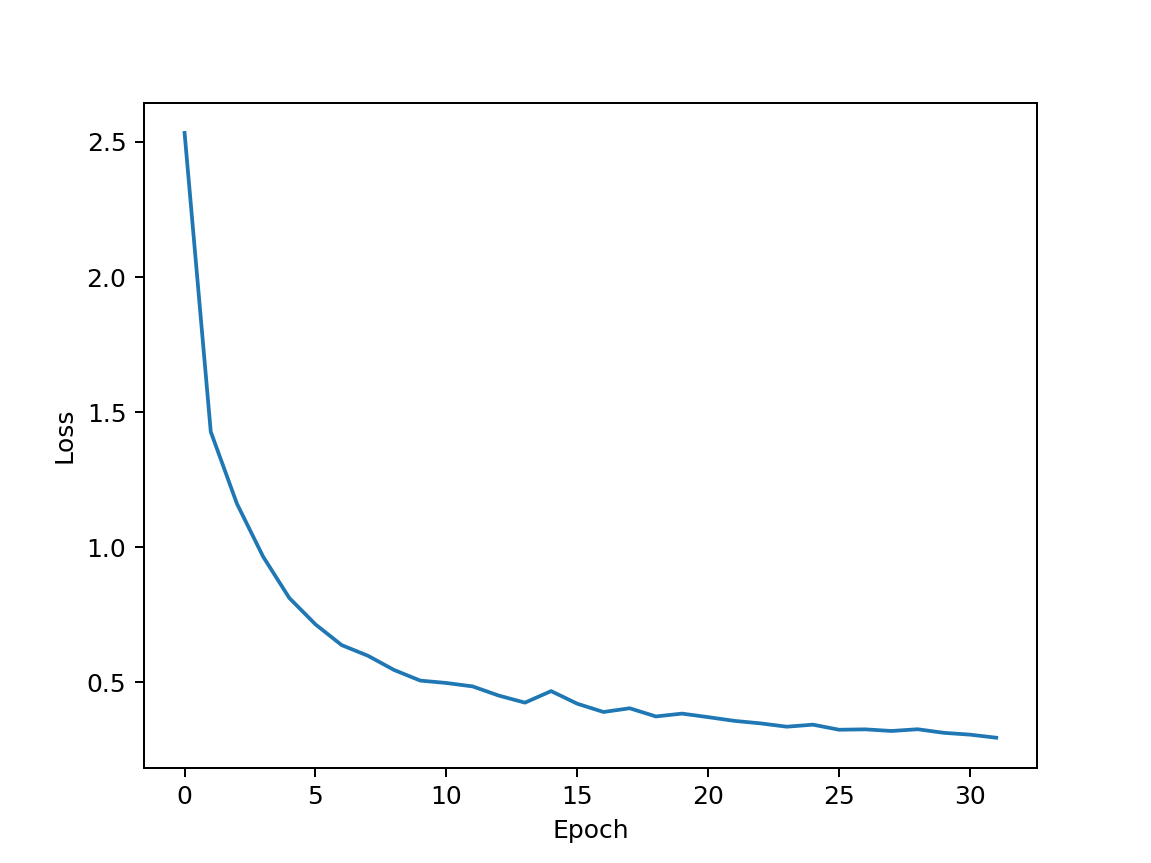

In [15]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

### Evaluate a test set

Do this on the CPU because I keep running out of memory on the gpu

In [19]:
model.eval()

LSTMTrackFinder (
  (lstm): LSTM(50, 100, batch_first=True)
  (fc): Linear (100 -> 50)
)

In [16]:
# Generate a test set
n_test = 10240
test_events, test_tracks = next(
    batch_generator(n_test, det_shape, seed_size=seed_size,
                    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob))

test_input = np_to_torch(test_events)
test_labels = np_to_torch(test_tracks.argmax(axis=2))

In [20]:
# Calculate test set predictions
test_logits = model(test_input)
test_preds = logits_to_probs(test_logits)
test_loss = model.cost_function(test_logits, test_labels)

print('Final test loss', test_loss.data[0])

Final test loss 0.276912719011


In [21]:
# Compute pixel accuracy
test_matches = (test_logits.max(dim=2)[1] == test_labels)
test_pixel_acc = test_matches.data.sum() / float(test_labels.numel())

# Compute hit accuracy
test_masked_matches = ((test_preds * test_input).max(dim=2)[1] == test_labels)
test_hit_acc = test_masked_matches.data.sum() / float(test_labels.numel())

print('Pixel classification accuracy', test_pixel_acc)
print('Hit classification accuracy', test_hit_acc)

Pixel classification accuracy 0.90134375
Hit classification accuracy 0.90164453125


<IPython.core.display.Javascript object>


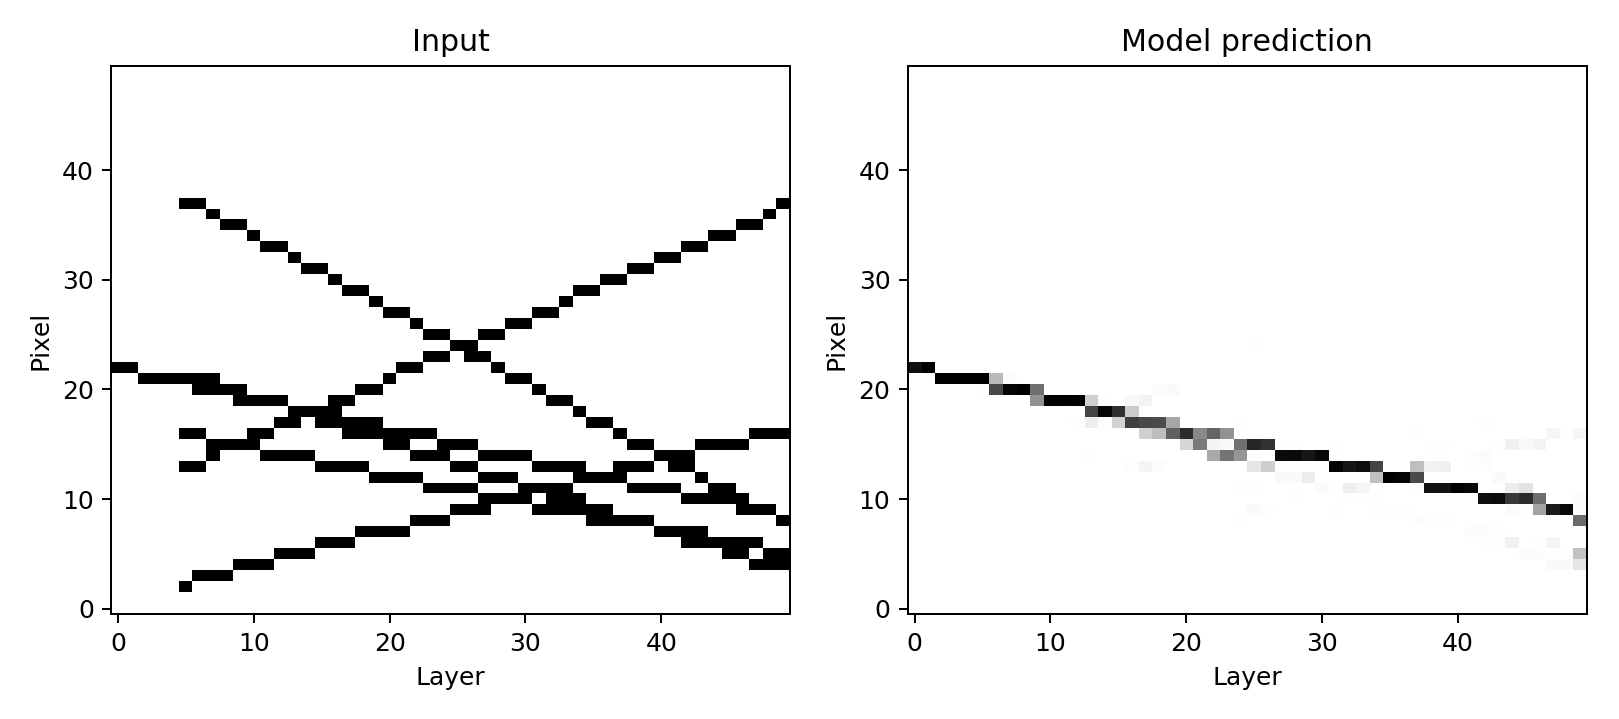

In [24]:
# Draw an event
i = 0
draw_2d_input_and_pred(test_input[i].cpu().data.numpy(), test_preds[i].cpu().data.numpy(), cmap='gray_r');

## Forward filter LSTM model

This is the model I always wanted to try, but was hindered by Keras.

An LSTM + FC will emit a prediction for each detector layer which is combined with the data and then fed back into the model for the extrapolation to the next layer. This forms a kind of attention mechanism.

The combination of the prediction with the data could happen in a few ways.
- simple element-wise product
- concatenate
- combine with FC

The element-wise product seems pretty easy for a first start. Let's do that now.

In [ ]:
class ForwardFilterTracker(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(ForwardFilterTracker, self).__init__()
        self.lstm = nn.LSTMCell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        input_size = x.size()
        
        # Initialize LSTM state
        h = create_tensor_var(input_size[0], self.lstm.hidden_size)
        c = create_tensor_var(input_size[0], self.lstm.hidden_size)
        
        outputs = []
        
        # For the first layer, pass input directly to output
        outputs.append(x[:, 0])
        
        # Loop over each remaining detector layer
        for i in range(1, input_size[1]):
            
            # Previous output is fed into the network
            h, c = self.lstm(outputs[-1], (h, c))            
            # Output is transformed to prediction on next detector layer
            p = self.fc(h)
            # Combine prediction with data, normalize with softmax.
            outputs.append(F.softmax(p * x[:, i]))
        
        # Stack the outputs together
        return torch.stack(outputs, dim=1)

    @staticmethod
    def cost_function(probs, labels):
        # Flatten the batch and detector layer dimensions
        flat_probs = probs.view(-1, probs.size(-1))
        flat_labels = labels.view(-1)
        return F.nll_loss(torch.log(flat_probs), flat_labels)

In [26]:
# CUDA memory allocations
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()

In [43]:
# Model config
hidden_dim = 100

# Train config
n_epochs = 128
n_batches = 512
batch_size = 32

In [ ]:
epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

In [ ]:
%%time

# Create the model
model2 = ForwardFilterTracker(det_width, hidden_dim)
if cuda:
    model2.cuda()
print(model2)
print('Parameters:', sum(param.numel() for param in model2.parameters()))
# Initialize the optimizer
optimizer = torch.optim.Adam(model2.parameters())

In [ ]:
# Training set batcher
train2_batcher = batch_generator(
    batch_size, det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_events, batch_tracks = next(train2_batcher)
        batch_input = np_to_torch(batch_events)
        batch_labels = np_to_torch(batch_tracks.argmax(axis=2))
        model2.zero_grad()
        batch_logits = model2(batch_input)
        batch_loss = model2.cost_function(batch_logits, batch_labels)
        batch_loss.backward()
        optimizer.step()
        sum_loss += batch_loss.data[0]
    
    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

<IPython.core.display.Javascript object>


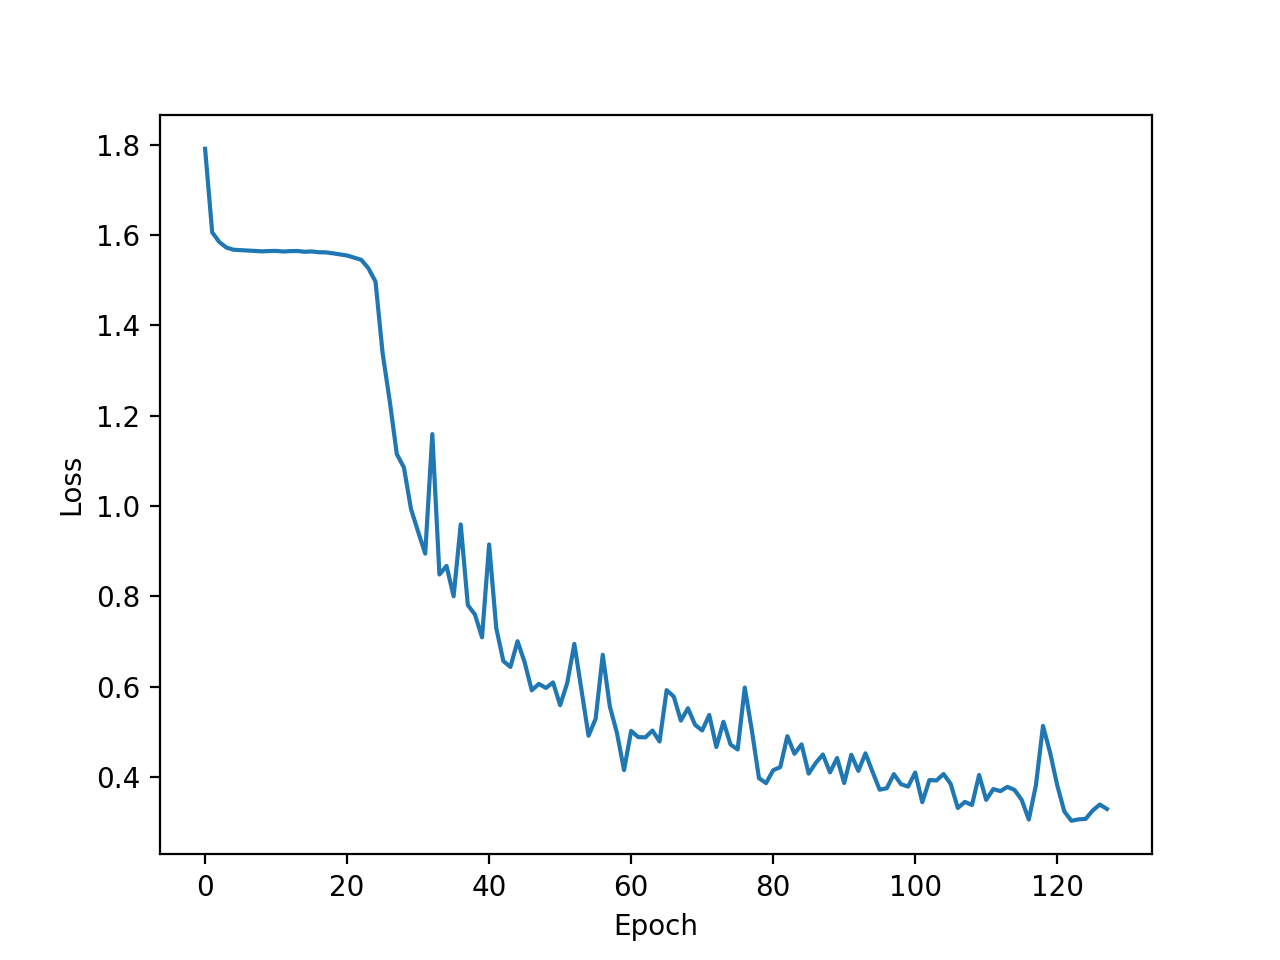

In [53]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# Inference mode supposedly consumes less memory
model2.eval()

In [54]:
# Calculate test set predictions and loss
test_outputs = model2(test_input)
test_loss = model2.cost_function(test_outputs, test_labels)
print('Test set loss', test_loss.data[0])

Test set loss 0.333480030298


In [55]:
# Compute pixel accuracy
test_matches = (test_outputs.max(dim=2)[1] == test_labels)
test_pixel_acc = test_matches.data.sum() / float(test_labels.numel())

# Compute hit accuracy
test_masked_matches = ((test_outputs * test_input).max(dim=2)[1] == test_labels)
test_hit_acc = test_masked_matches.data.sum() / float(test_labels.numel())

print('Pixel classification accuracy', test_pixel_acc)
print('Hit classification accuracy', test_hit_acc)

Pixel classification accuracy 0.8928671875
Hit classification accuracy 0.8928671875


<IPython.core.display.Javascript object>


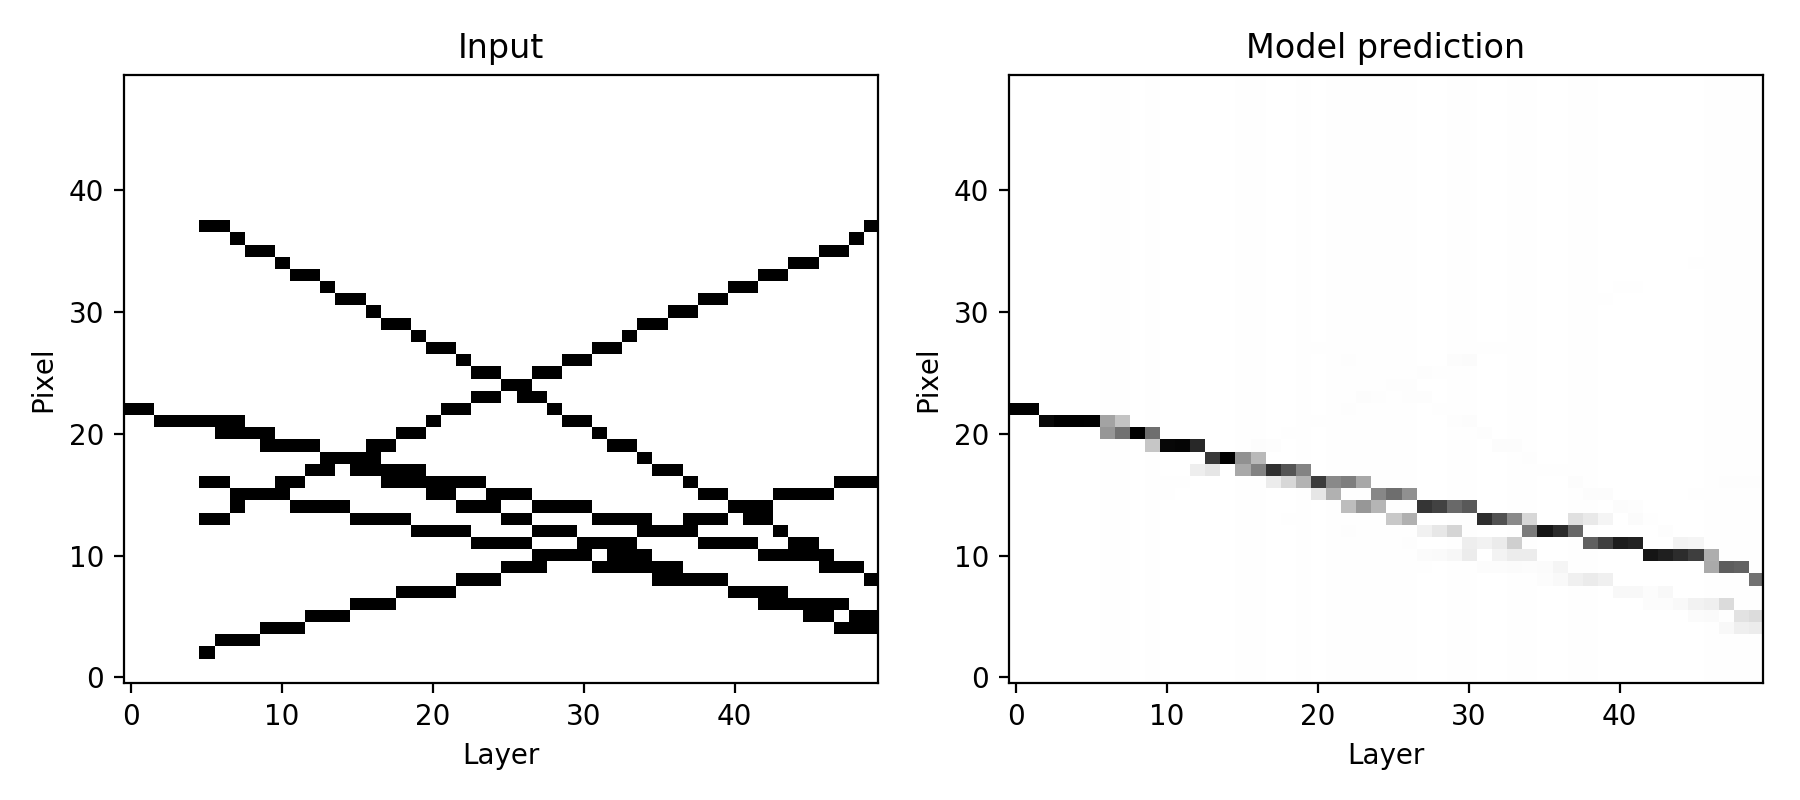

In [52]:
# Draw an event
i = 0
draw_2d_input_and_pred(test_input[i].cpu().data.numpy(), test_outputs[i].cpu().data.numpy(), cmap='gray_r');

### Discussion

This model is a bit harder to train than the simple LSTM model above. The loss as a function of epochs shows a slow escape from an initial plateau and then large fluctuations while converging.

This model may be suffering because
- it only sees what its attention allows it to see, which may limit its awareness to what background tracks are doing.

## Smarter forward filter model

New approach. In this model, at each layer the data is combined with a prior guess (from the seed or from extrapolation) to improve its state estimate. The output is split into a decoder which gives the final prediction on the current layer, and an extrapolator which produces the guess for the next layer.

In [6]:
# CUDA memory allocations
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_to_np = lambda x: x.cpu().data.numpy()

In [7]:
class ForwardFilterTracker2(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(ForwardFilterTracker2, self).__init__()
        self.encoder = nn.Linear(input_dim*2, hidden_dim)
        self.lstm = nn.LSTMCell(hidden_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.extrapolator = nn.Linear(hidden_dim, input_dim)
    
    def init_hidden_state(self, batch_size):
        return (create_tensor_var(batch_size, self.lstm.hidden_size),
                create_tensor_var(batch_size, self.lstm.hidden_size))
        
    def encode(self, x, prior):
        return F.sigmoid(self.encoder(torch.cat([x, prior], dim=1)))
    
    def decode(self, h):
        return F.softmax(self.decoder(h))
    
    def extrap(self, h):
        return F.softmax(self.extrapolator(h))
    
    def step(self, x, prior, h, c):
        """Encode data and prior and iterate the LSTM"""
        return self.lstm(self.encode(x, prior), (h, c))
    
    def forward(self, x, seed):
        input_size = x.size()
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(input_size[0])
        
        # Two sets of outputs: forward-predictions and final-predictions
        fwd_preds, fin_preds = [seed[:,0]], []
        
        # Loop over seed layers
        for i in range(seed.size(1)):
            # Iterate the model using the seed as the prior
            h, c = self.step(x[:,i], seed[:,i], h, c)
            fin_preds.append(self.decode(h))
            fwd_preds.append(self.extrap(h))
        
        # Loop over layers until last
        for i in range(seed.size(1), input_size[1] - 1):
            # Iterate the model using the forward-prediction as prior
            h, c = self.step(x[:,i], fwd_preds[-1], h, c)
            fin_preds.append(self.decode(h))
            fwd_preds.append(self.extrap(h))
        
        # Handle final layer; no extrapolation needed
        h, c = self.step(x[:,-1], fwd_preds[-1], h, c)
        fin_preds.append(self.decode(h))
        
        # Stack the outputs together
        return torch.stack(fwd_preds, dim=1), torch.stack(fin_preds, dim=1)

    @staticmethod
    def cost_function(fwd_probs, fin_probs, labels, fwd_frac=0.5):
        # Flatten the batch and detector layer dimensions
        fwd_probs = fwd_probs.view(-1, fwd_probs.size(-1))
        fin_probs = fin_probs.view(-1, fin_probs.size(-1))
        labels = labels.view(-1)
        # Compute the losses and sum them
        fwd_loss = F.nll_loss(torch.log(fwd_probs), labels)
        fin_loss = F.nll_loss(torch.log(fin_probs), labels)
        return fwd_frac * fwd_loss + (1 - fwd_frac) * fin_loss

In [28]:
# Model config
hidden_dim = 100

# Train config
n_epochs = 128
n_batches = 512
batch_size = 256
fwd_weight = 0.5

In [29]:
epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

131072 samples per epoch
16777216 total samples for training


In [30]:
%%time

# Create the model and optimizer
model3 = ForwardFilterTracker2(det_width, hidden_dim)
#optimizer = torch.optim.SGD(model3.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model3.parameters())

if cuda: model3.cuda()
print(model3)
print('Parameters:', sum(param.numel() for param in model3.parameters()))

ForwardFilterTracker2 (
  (encoder): Linear (100 -> 100)
  (lstm): LSTMCell(100, 100)
  (decoder): Linear (100 -> 50)
  (extrapolator): Linear (100 -> 50)
)
Parameters: 101000
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.39 ms


In [ ]:
# Training set batcher
train3_batcher = batch_generator(
    batch_size, det_shape, seed_size=0,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        model3.zero_grad()
        batch_events, batch_tracks = next(train3_batcher)
        batch_input = np_to_torch(batch_events)
        batch_seeds = np_to_torch(batch_tracks[:,:seed_size])
        batch_labels = np_to_torch(batch_tracks.argmax(axis=2))
        batch_output = model3(batch_input, batch_seeds)
        batch_loss = model3.cost_function(batch_output[0], batch_output[1], batch_labels, fwd_weight)
        batch_loss.backward()
        optimizer.step()
        sum_loss += batch_loss.data[0]
    
    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 3.135 time 65.0615s
Epoch 1
  average loss 2.266 time 65.6418s
Epoch 2
  average loss 1.792 time 65.7336s
Epoch 3
  average loss 1.525 time 65.3604s
Epoch 4
  average loss 1.412 time 66.1864s
Epoch 5
  average loss 1.267 time 67.3514s
Epoch 6
  average loss 1.235 time 66.2642s
Epoch 7
  average loss 1.138 time 67.4273s
Epoch 8
  average loss 1.075 time 66.3945s
Epoch 9
  average loss 1.144 time 65.5616s
Epoch 10
  average loss 1.079 time 65.6651s
Epoch 11
  average loss 1.131 time 65.136s
Epoch 12
  average loss 1.102 time 66.6469s
Epoch 13
  average loss 1.419 time 66.0992s
Epoch 14
  average loss 1.257 time 66.667s
Epoch 15
  average loss 1.144 time 65.3234s
Epoch 16
  average loss 0.963 time 67.1484s
Epoch 17
  average loss 0.985 time 65.9921s
Epoch 18
  average loss 0.926 time 64.9362s
Epoch 19
  average loss 1.120 time 64.2893s
Epoch 20
  average loss 0.958 time 65.6063s
Epoch 21
  average loss 1.045 time 66.8046s
Epoch 22
  average loss 1.290 time 64.9885s


<IPython.core.display.Javascript object>


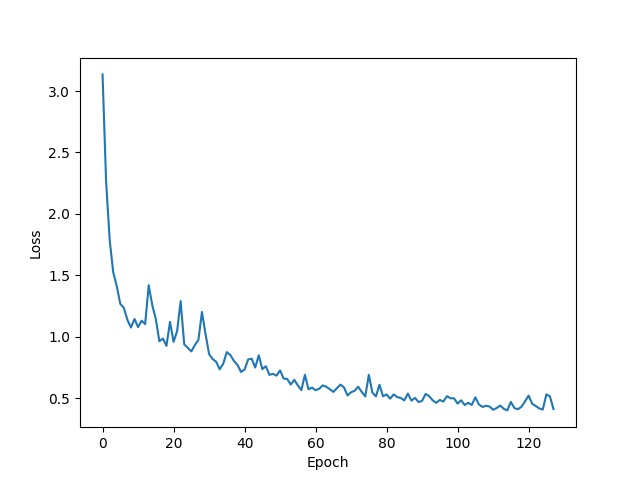

In [33]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [34]:
# Inference mode supposedly consumes less memory
model3.eval()

ForwardFilterTracker2 (
  (encoder): Linear (100 -> 100)
  (lstm): LSTMCell(100, 100)
  (decoder): Linear (100 -> 50)
  (extrapolator): Linear (100 -> 50)
)

In [35]:
# Generate a new test set
n_test = 10240
test3_events, test3_tracks = next(
    batch_generator(n_test, det_shape, seed_size=0,
                    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob))

test3_input = np_to_torch(test3_events)
test3_seeds = np_to_torch(test3_tracks[:,:seed_size])
test3_labels = np_to_torch(test3_tracks.argmax(axis=2))

In [36]:
# Calculate test set predictions and loss
test3_outputs = model3(test3_input, test3_seeds)
test3_loss = model3.cost_function(test3_outputs[0], test3_outputs[1], test3_labels)
print('Test set loss', test3_loss.data[0])

Test set loss 0.391657471657


In [37]:
def pixel_accuracy(outputs, labels):
    matches = (outputs.max(dim=2)[1] == labels)
    return matches.data.sum() / float(labels.numel())

def hit_accuracy(inputs, outputs, labels):
    matches = ((outputs * inputs).max(dim=2)[1] == labels)
    return matches.data.sum() / float(labels.numel())

In [38]:
# Compute forward prediction accuracy
print('Forward prediction accuracies')
print('  pixel', pixel_accuracy(test3_outputs[0], test3_labels))
print('  hit  ', hit_accuracy(test3_input, test3_outputs[0], test3_labels))

Forward prediction accuracies
  pixel 0.7955078125
  hit   0.9430546875


In [39]:
print('Final prediction accuracies')
print('  pixel', pixel_accuracy(test3_outputs[1], test3_labels))
print('  hit  ', hit_accuracy(test3_input, test3_outputs[1], test3_labels))

Final prediction accuracies
  pixel 0.944873046875
  hit   0.9463203125


<IPython.core.display.Javascript object>


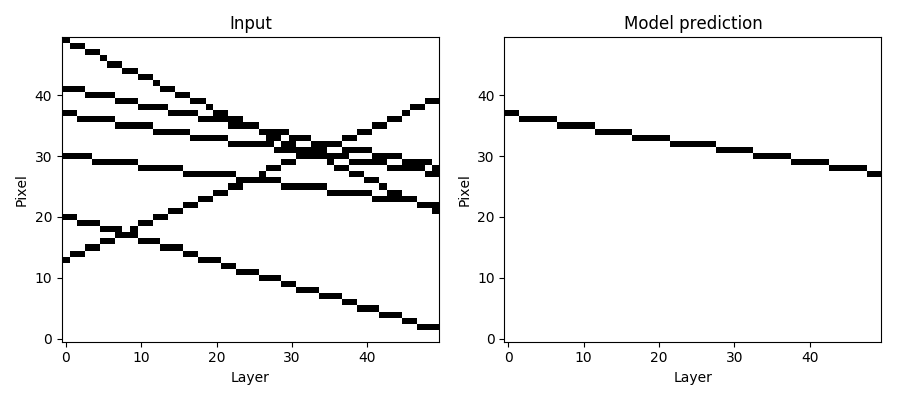

<IPython.core.display.Javascript object>


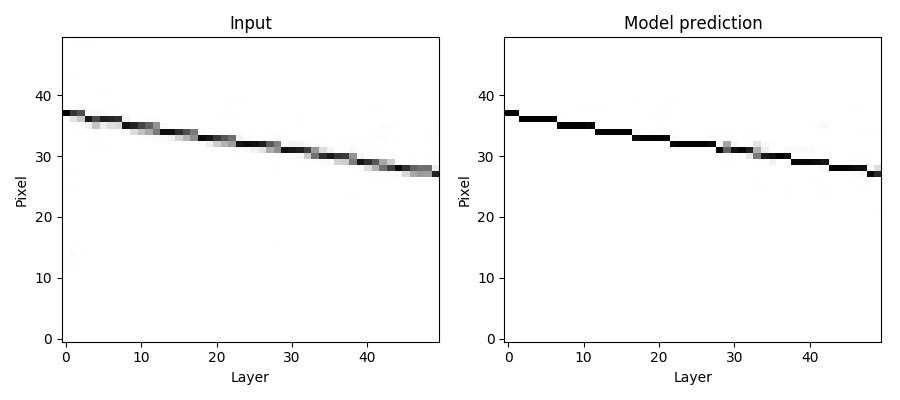

In [45]:
# Draw an event
i = 5
draw_2d_input_and_pred(test3_events[i], test3_tracks[i], cmap='gray_r');
draw_2d_input_and_pred(torch_to_np(test3_outputs[0][i]), torch_to_np(test3_outputs[1][i]), cmap='gray_r');

### Discussion

This model can clearly learn and perform well on this toy data, but it takes a _lot_ of training to get to good performance. Maybe there are ways to speed it up, but it's a little tough to believe that for a fixed amount of data this model can outperform the simpler lstm model. Still, I think this approach has very nice motivations and might be more useful in more complex scenarios.